# **Baseline Models with Basic Vectorization**
# **CIS 5190 Group Project**
By 	Mona Gandhi, Jeffrey Li, Henil Satra <br>

# Imports/Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns


# preprocessing
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# classification
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk
From (redirected): https://drive.google.com/uc?id=1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk&confirm=t&uuid=a51a3d11-6edc-423c-936d-a58bc576b1e0
To: /content/Reviews.csv
100% 301M/301M [00:01<00:00, 192MB/s]


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Loading


In [ ]:
reviews_df = pd.read_csv('Reviews.csv')

In [ ]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Data Preparation

In [ ]:
reviews_df = reviews_df[['Text', 'Score']]

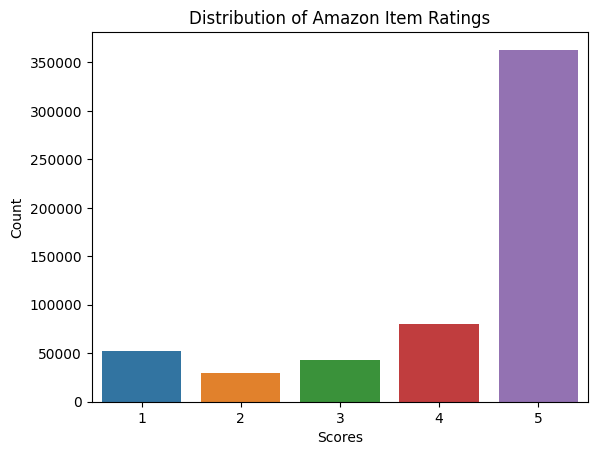

In [ ]:
sns.countplot(x=reviews_df.Score)
plt.xlabel('Scores')
plt.ylabel("Count")
plt.title("Distribution of Amazon Item Ratings")
plt.show()

In [ ]:
# create labels: "Positive" and "Negative"
reviews_df['Label'] = reviews_df['Score'].apply(lambda x: "Positive" if x > 3 else "Negative")

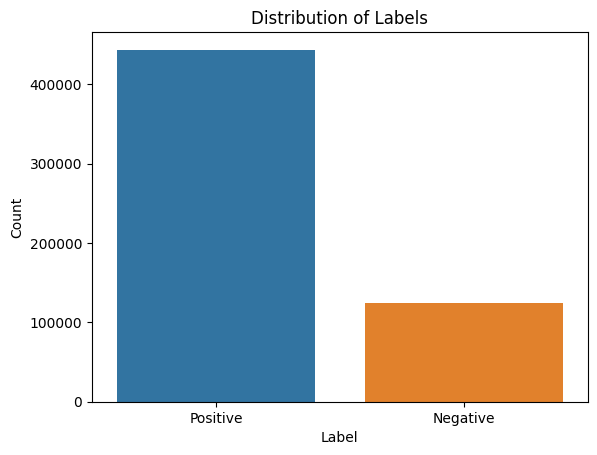

In [ ]:
sns.countplot(x=reviews_df.Label)
plt.xlabel('Label')
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# Data Preprocessing

In [ ]:
reviews_df = reviews_df[reviews_df['Text'].notna()]

In [ ]:
reviews_df = reviews_df[reviews_df['Text'].apply(lambda x: len(x.split()) != 0)]

In [ ]:
NUMBERS_RE = re.compile('[^0-9]+')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    result = re.match(r"[0-9]+", text)
    if result != None:
      text = NUMBERS_RE.sub('X', text)

    text = text.replace('X', '')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

reviews_df['Text'] = reviews_df['Text'].apply(clean_text)

In [ ]:
reviews_df.head()

,Text,Score,Label
0,bought several vitality canned dog food produc...,5,Positive
1,product arrived labeled jumbo salted peanutsth...,1,Negative
2,confection around centuries light pillowy citr...,4,Positive
3,looking secret ingredient robitussin believe f...,2,Negative
4,great taffy great price wide assortment yummy ...,5,Positive


In [ ]:
reviews_df.shape

(568454, 3)

## Vectorization

In [ ]:
print("MAX review length: ", reviews_df['Text'].apply(lambda x: len(x.split())).max())
print("MIN review length: ", reviews_df['Text'].apply(lambda x: len(x.split())).min())
print("MEAN review length: ", reviews_df['Text'].apply(lambda x: len(x.split())).mean())

MAX review length:  1988
MIN review length:  1
MEAN review length:  41.69464371787339


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(reviews_df['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 212300 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(reviews_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (568454, 100)


In [ ]:
y = np.where(reviews_df['Label']=='Positive', 1, 0)

In [ ]:
# y = pd.get_dummies(reviews_df['Label']).values # original one hot encoding was spitting out y of 2 dimensions, not sure if that was intended or not 
print('Shape of label tensor:', y.shape)

Shape of label tensor: (568454,)


## Train-Test Split

In [ ]:
# train test split 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
X_train

array([[   0,    0,    0, ...,    8,   16,   23],
       [   0,    0,    0, ...,   70,  176,   65],
       [   0,    0,    0, ..., 3999,  155,   66],
       ...,
       [   0,    0,    0, ...,  265,   48,   52],
       [   0,    0,    0, ..., 8197, 4968,  285],
       [   0,    0,    0, ...,    4,  590,  563]], dtype=int32)

In [ ]:
type(X_train[0][0])

numpy.int32

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(454763, 100)
(113691, 100)
(454763,)
(113691,)


## Random Undersampling

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under= rus.fit_resample(X_train_copy, y_train_copy)

In [ ]:
print('Undersampled X dimensions: ', X_train_under.shape)
print('Undersampled y dimensions: ', y_train_under.shape)

Undersampled X dimensions:  (200022, 100)
Undersampled y dimensions:  (200022,)


In [ ]:
import collections
collections.Counter(y_train_under)

Counter({0: 100011, 1: 100011})

## Random Oversampling

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over= ros.fit_resample(X_train_copy, y_train_copy)

In [ ]:
print('Oversampled X dimensions: ', X_train_over.shape)
print('Oversampled y dimensions: ', y_train_over.shape)

Oversampled X dimensions:  (709504, 100)
Oversampled y dimensions:  (709504,)


In [ ]:
import collections
collections.Counter(y_train_over)

Counter({0: 354752, 1: 354752})

# Baseline Classification Models

## Experiment: Undersampling

### Naive Bayes

In [ ]:
# naive bayes fit and predict
nb_clf_under = BernoulliNB().fit(X_train_under, y_train_under) 
y_pred = nb_clf_under.predict(X_test)

In [ ]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.6055536498051737

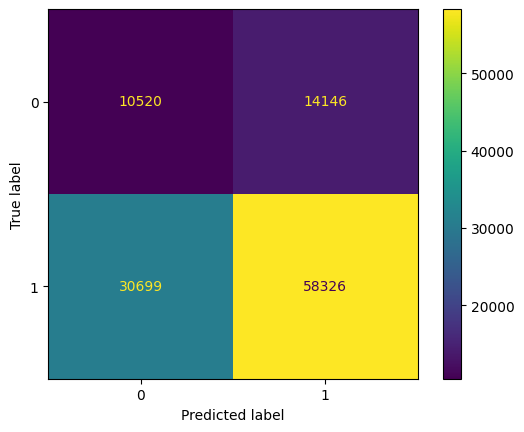

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  10520
False Positive:  14146
False Negative:  30699
True Positive:  58326


ROC Area Under the Curve:  0.5408311465782688


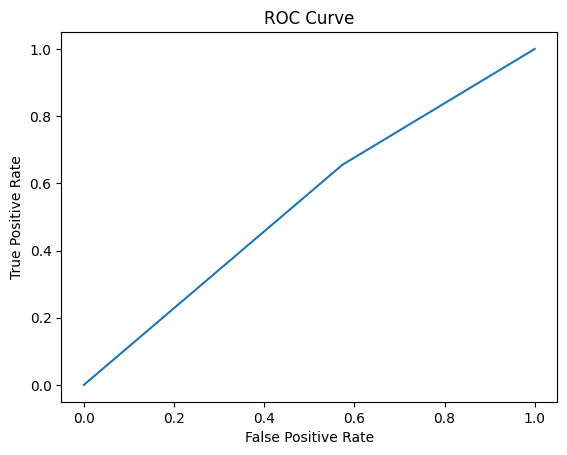

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7223168232227224


#### Hyperparameter Tuning

In [ ]:
nb_clf_under = BernoulliNB()
nb_clf_under.get_params()

{'alpha': 1.0,
 'binarize': 0.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': 'warn'}

In [ ]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
nb_clf_under = GridSearchCV(nb_clf_under, param, n_jobs=-1, cv=cv)
result = nb_clf_under.fit(X_train_under, y_train_under)
y_pred = nb_clf_under.predict(X_test)

In [ ]:
print("best hyperparameters: ", nb_clf_under.best_params_)

best hyperparameters:  {'alpha': 0.1, 'fit_prior': True}


In [ ]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.6055536498051737

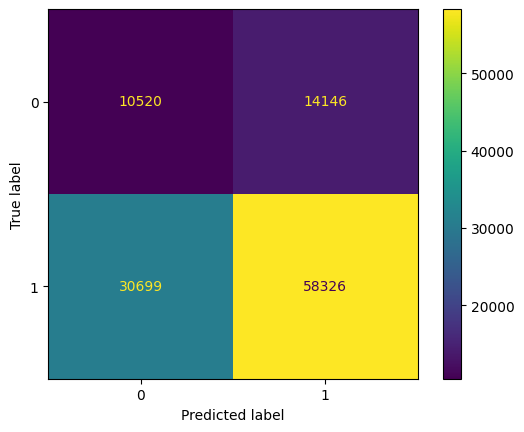

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  10520
False Positive:  14146
False Negative:  30699
True Positive:  58326


ROC Area Under the Curve:  0.5408311465782688


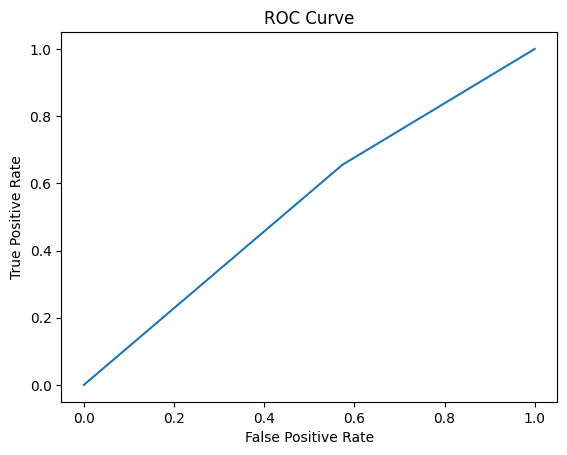

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7223168232227224


###  Logistic Regression

In [ ]:
# logistic regression fit and predict
lr_clf_under = LogisticRegression().fit(X_train_under, y_train_under) 
y_pred = lr_clf_under.predict(X_test)

In [ ]:
# model accuracy
log_acc = accuracy_score(y_test, y_pred)
log_acc

0.4267444212822475

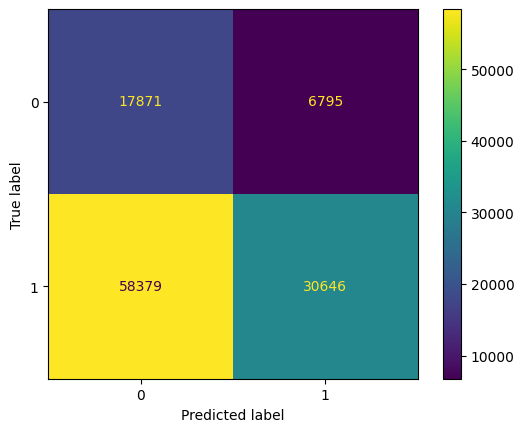

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17871
False Positive:  6795
False Negative:  58379
True Positive:  30646


ROC Area Under the Curve:  0.5343799817627531


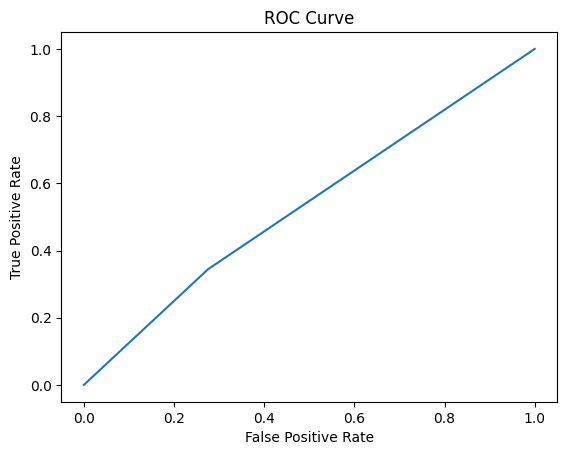

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.48465200132842023


#### Hyperparameter Tuning

In [ ]:
lr_clf_under = LogisticRegression()
lr_clf_under.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#grid search to tune the hyperparameters

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2']
}
lr_clf_under = GridSearchCV(lr_clf_under, param, n_jobs=-1, cv=cv)
result = lr_clf_under.fit(X_train_under, y_train_under)
y_pred = lr_clf_under.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver l

In [ ]:
print("best hyperparameters: ", lr_clf_under.best_params_)

best hyperparameters:  {'C': 0.1, 'penalty': 'l2'}


In [ ]:
# model accuracy
lr_acc = accuracy_score(y_test, y_pred)
lr_acc

0.4267444212822475

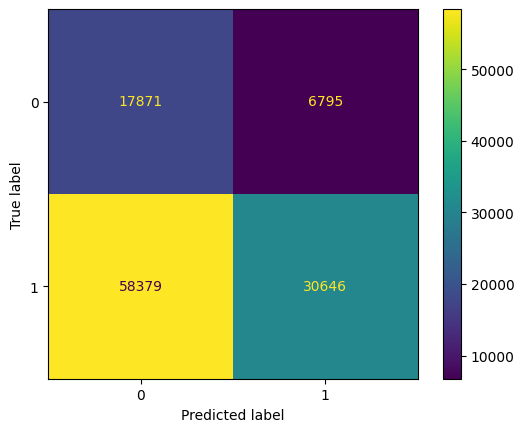

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17871
False Positive:  6795
False Negative:  58379
True Positive:  30646


ROC Area Under the Curve:  0.5343799817627531


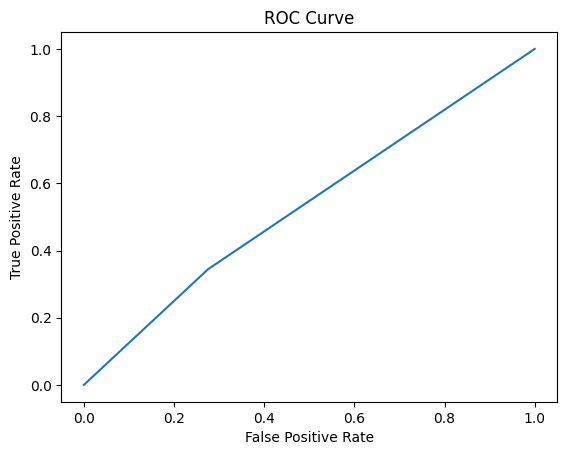

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.48465200132842023


###  XGBoost

In [ ]:
# xgboost fit and predict
xgb_clf_under = xgb.XGBClassifier().fit(X_train_under, y_train_under) 
y_pred = xgb_clf_under.predict(X_test)

In [ ]:
# model accuracy
xgb_acc = accuracy_score(y_test, y_pred)
xgb_acc

0.7041014680141788

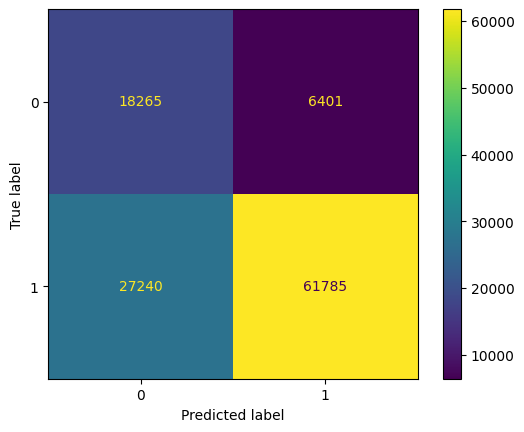

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  18265
False Positive:  6401
False Negative:  27240
True Positive:  61785


ROC Area Under the Curve:  0.7172557602082781


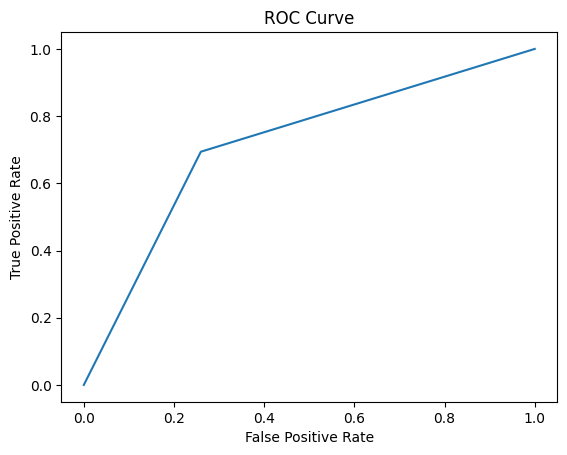

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7860137013313317


## Experiment: Oversampling

### Naive Bayes

In [ ]:
# naive bayes fit and predict
nb_clf_over = BernoulliNB().fit(X_train_over, y_train_over) 
y_pred = nb_clf_over.predict(X_test)

In [ ]:
# model accuracy
nb_acc = accuracy_score(y_test, y_pred)
nb_acc

0.6055536498051737

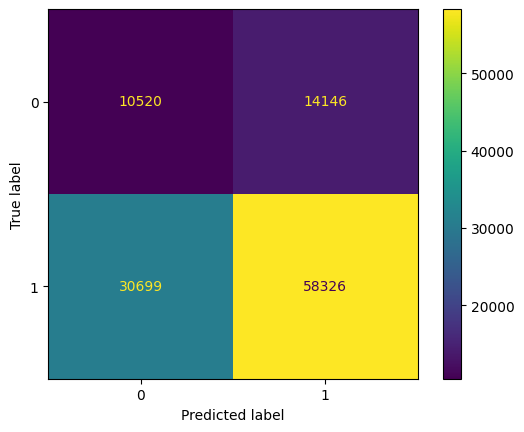

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_clf_over.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_over.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  10520
False Positive:  14146
False Negative:  30699
True Positive:  58326


ROC Area Under the Curve:  0.5408311465782688


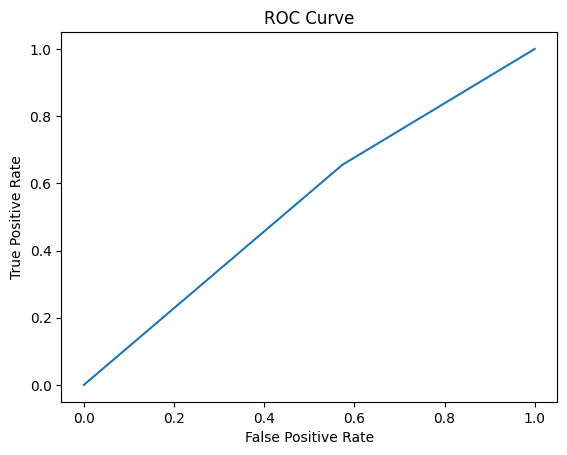

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7223168232227224


###  Logistic Regression

In [ ]:
# logistic regression fit and predict
lr_clf_over = LogisticRegression().fit(X_train_over, y_train_over) 
y_pred = lr_clf_over.predict(X_test)

In [ ]:
# model accuracy
log_acc = accuracy_score(y_test, y_pred)
log_acc

0.4280110123052836

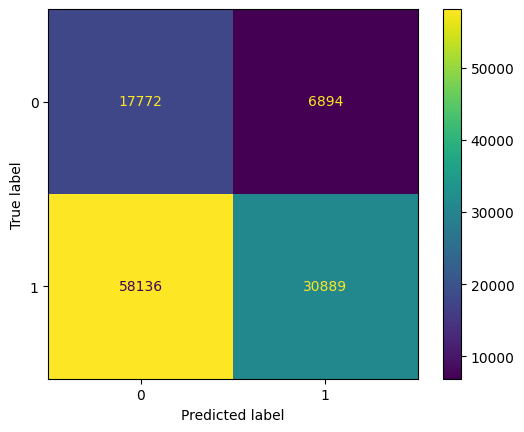

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=lr_clf_over.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_over.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17772
False Positive:  6894
False Negative:  58136
True Positive:  30889


ROC Area Under the Curve:  0.5337379559405656


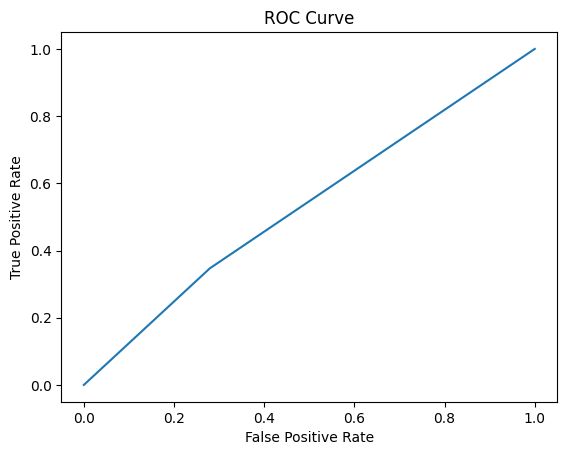

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.48717746514415494


###  XGBoost

In [ ]:
# xgboost fit and predict
xgb_clf_over = xgb.XGBClassifier().fit(X_train_over, y_train_over) 
y_pred = xgb_clf_over.predict(X_test)

In [ ]:
# model accuracy
xgb_acc = accuracy_score(y_test, y_pred)
xgb_acc

0.7241822131918974

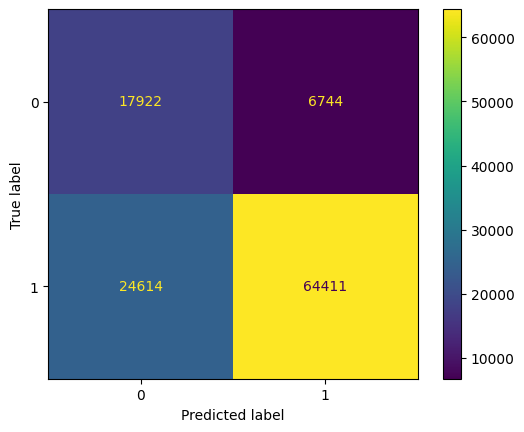

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf_over.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_over.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  17922
False Positive:  6744
False Negative:  24614
True Positive:  64411


ROC Area Under the Curve:  0.7250515356946395


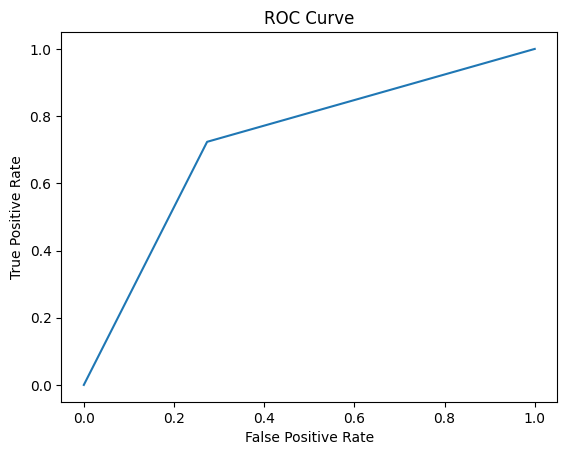

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8042327381695593


# Dataset Shift

In [ ]:
if not os.path.exists("/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv"):
  !gdown 1UC7svIwq3ZDwI1sxZoTU7s7qmgKABuXp

In [ ]:
movies_df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/CIS5190-Project/Work/Data/IMDB Dataset.csv')

In [ ]:
movies_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


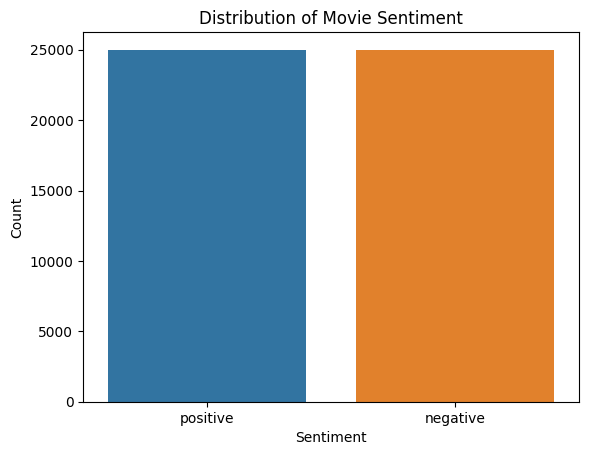

In [ ]:
sns.countplot(x=movies_df.sentiment)
plt.xlabel('Sentiment')
plt.ylabel("Count")
plt.title("Distribution of Movie Sentiment")
plt.show()

## Preprocessing

In [ ]:
movies_df = movies_df[movies_df['review'].notna()]
movies_df = movies_df[movies_df['review'].apply(lambda x: len(x.split()) != 0)]
movies_df['review'] = movies_df['review'].apply(clean_text)

In [ ]:
movies_df.shape

(50000, 2)

In [ ]:
X = tokenizer.texts_to_sequences(movies_df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (50000, 100)


In [ ]:
y = np.where(movies_df['sentiment']=='positive', 1, 0)
print('Shape of label tensor:', y.shape)

Shape of label tensor: (50000,)


## Testing the models on the entire dataset


### Naive Bayes

In [ ]:
# naive bayes predict
y_pred = nb_clf_under.predict(X)
# model accuracy
nb_acc = accuracy_score(y, y_pred)
print("Accuracy for Naive Bayes: ", nb_acc)

Accuracy for Naive Bayes:  0.51272


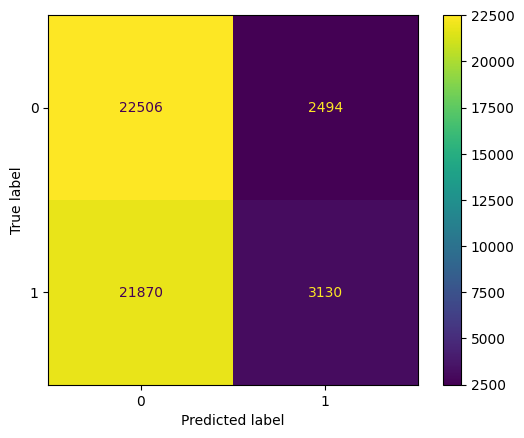

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=nb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  22506
False Positive:  2494
False Negative:  21870
True Positive:  3130


ROC Area Under the Curve:  0.51272


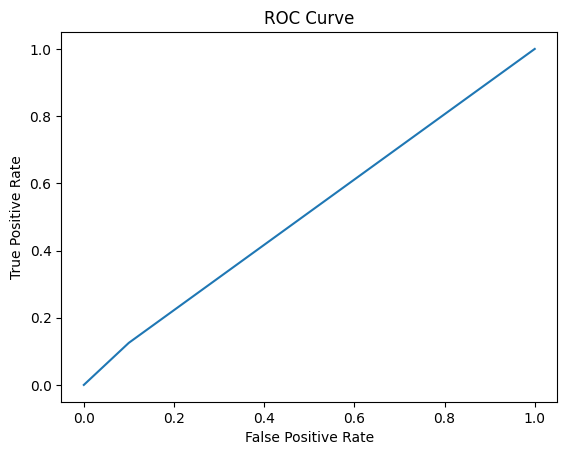

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.20441483803552774


### Logistic Regression

In [ ]:
# logistic regression predict
y_pred = lr_clf_under.predict(X)
# model accuracy
lr_acc = accuracy_score(y, y_pred)
print("Accuracy for Logistic Regression: ", lr_acc)

Accuracy for Logistic Regression:  0.50394


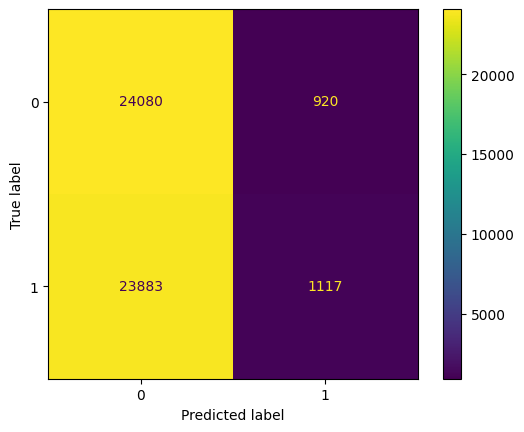

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=lr_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  24080
False Positive:  920
False Negative:  23883
True Positive:  1117


ROC Area Under the Curve:  0.50394


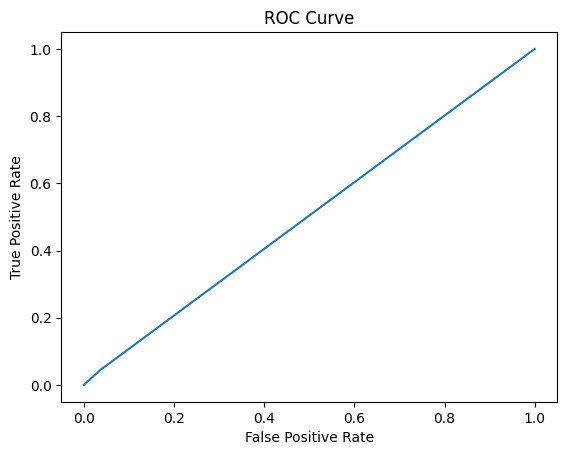

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.08262751044864444


### XGBoost

In [ ]:
# xgboost predict
y_pred = xgb_clf_under.predict(X)
# model accuracy
xgb_acc = accuracy_score(y, y_pred)
print("Accuracy for XGBoost: ", xgb_acc)

Accuracy for XGBoost:  0.55718


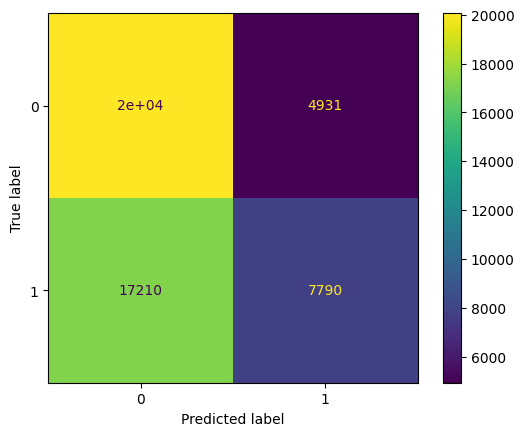

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred, labels=xgb_clf_under.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf_under.classes_)
disp.plot()

In [ ]:
# false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  20069
False Positive:  4931
False Negative:  17210
True Positive:  7790


ROC Area Under the Curve:  0.55718


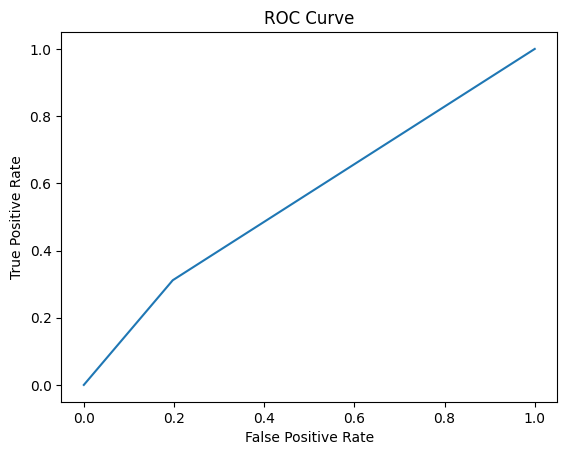

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y, y_pred))
fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y, y_pred, average='binary'))

F1 Score:  0.413032528299886


# Save Models

In [ ]:
import os
import joblib

In [ ]:
path = "/content/drive/MyDrive/CIS5190-Project/Work/Models"

In [ ]:
filename = "nb_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(nb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/nb_model.pkl']

In [ ]:
filename = "lr_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(lr_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/lr_model.pkl']

In [ ]:
filename = "xgb_model.pkl"
if not os.path.exists(path):
    os.makedirs(path)
joblib.dump(xgb_clf_under, os.path.join(path, filename))

['/content/drive/MyDrive/CIS5190-Project/Work/Models/xgb_model.pkl']